In [1]:
import sys
import gym
import numpy as np
import random
from collections import defaultdict

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # obtains the action probabilities corresponding to epsilon-greedy policy
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s
  
''' 
Now we will use this get_probs func in generating the episode. 
Note that we are no longer using the stochastic policy we started with, instead building upon it in an epsilon greedy way.
'''
def generate_episode_from_Q(env, Q, epsilon, nA):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

''' 
Finally Q values are approximated by taking average of corresponding returns.
But instead we can write it using incremental mean and constant alpha.
As we are using constant alpha we need not keep a track of N-table, ie how many times we visited that state.
''' 

def update_Q(env, episode, Q, alpha, gamma):
    # updates the action-value function estimate using the most recent episode 
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [4]:
def ori_policy_implementation(Q, policy, iter):
    rewards = []
    nA=env.action_space.n
    for i_episode in range(iter):
        state = env.reset()
        while True:
            action = np.random.choice(np.arange(nA), p=get_probs(Q[state], 0, nA)) \
                                        if state in Q else env.action_space.sample()
            next_state, reward, done, info = env.step(action)
            state = next_state
            rewards.append(reward)
            if done:
                break

    return rewards

In [5]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start

    ep_rewards = []
    avg = 0
    count = 0

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
        # determine the policy corresponding to the final action-value function estimate
        policy = dict((k,np.argmax(v)) for k, v in Q.items())
        
        ep_reward = ori_policy_implementation(Q, policy, 5)

        if len(ep_reward) > 0:
            count += 1
            avg += (1/count)*(np.array(ep_reward).mean() - avg)
            ep_rewards.append(avg)
        else:
            ep_rewards.append(avg)
            
    
    return policy, Q, ep_rewards

In [6]:
def episodes_off_policy(env):

    nA = env.action_space.n
    probs = np.array([1/nA for _ in range(nA)])

    e = []
    s = env.reset()

    while True:
        action = np.random.choice(np.arange(nA), p = probs)
        
        next, r, d, _ = env.step(action)
        e.append((s, action, r))
        s = next
        if d:
          break
    
    return e

In [7]:
def off_policy_implementation(Q, policy, iter):
    nA=env.action_space.n
    r = []
    for i_episode in range(iter):
        state = env.reset()
        while True:
            if state in policy:
                action = policy[state]
            else:
                action = np.random.choice(np.arange(nA))
            next_state, reward, done, info = env.step(action)
            state = next_state
            if done:
                break
        r.append(reward)
    return r

In [8]:
def mc_control_off_policy(env, num_episodes, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):

    nA = env.action_space.n
    Q = {}
    C = {}
    epsilon = eps_start

    rewards_list = []
    avg = 0

    for i in range(num_episodes):

        if i % 1000 == 0:
            print("\rEpisode {}/{}.".format(i, num_episodes), end="")
            sys.stdout.flush()
        
        episode = episodes_off_policy(env)
        
        W = 1
        G = 0

        for ep in episode:
            state, action, reward = ep

            G = gamma*G + reward

            if state not in Q:
                Q[state] = np.zeros(nA)
                C[state] = np.zeros(nA)

            C[state][action] += W
            Q[state][action] += (W/C[state][action])*(G - Q[state][action])

            pol = np.argmax(Q[state])

            if pol != action:
                break

            W += W*(1/(1/nA))
        policy = dict((k,np.argmax(v)) for k, v in Q.items())
        rewards = off_policy_implementation(Q, policy, 5)
        rewards_mean = np.array(rewards).mean()
        avg += (1/(i+1))*(rewards_mean - avg)
        rewards_list.append(avg)
    
    return policy, Q, rewards_list

In [9]:
policy, Q, ori_rewards = mc_control(env, 500000, 0.015)

Episode 500000/500000.

In [10]:
policy, Q, rewards_off_policy = mc_control_off_policy(env, 500000)

Episode 499000/500000.

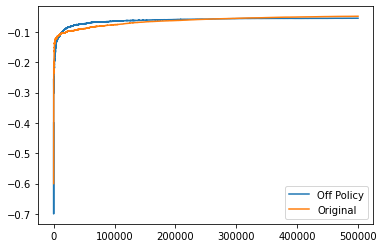

In [11]:
import matplotlib.pyplot as plt
plt.plot(rewards_off_policy, label = 'Off Policy')
plt.plot(ori_rewards, label = 'Original')
plt.legend()
plt.show()